In [1]:
import pandas as pd
import requests
import time
from lxml import html
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["SimHei"] #用来正常显示中文标签
plt.rcParams["axes.unicode_minus"]=False #用来正常显示负号

## 爬取数据

由于没有豆瓣电影Top250现成的数据，所以我们自己写个简单爬虫去爬取这个数据。豆瓣电影Top250的网址见 `https://movie.douban.com/top250`。

我们多点击几页之后，发现每页的url是有规律的，第一页是：`https://movie.douban.com/top250?start=0&filter=`，第二页是：`https://movie.douban.com/top250?start=25&filter=`。也就是 start 参数有变化，每一页的取值为 `(页数-1) * 25`。

这样我们就能通过for循环获取到要抓取的所有的页数。

In [2]:
for i in range(10): 
    url = "https://movie.douban.com/top250?start={}&filter=".format(i*25)
    print(url)

https://movie.douban.com/top250?start=0&filter=
https://movie.douban.com/top250?start=25&filter=
https://movie.douban.com/top250?start=50&filter=
https://movie.douban.com/top250?start=75&filter=
https://movie.douban.com/top250?start=100&filter=
https://movie.douban.com/top250?start=125&filter=
https://movie.douban.com/top250?start=150&filter=
https://movie.douban.com/top250?start=175&filter=
https://movie.douban.com/top250?start=200&filter=
https://movie.douban.com/top250?start=225&filter=


已经知道了所有的页数如何获取，来看下如何从每页中获取想要的数据。这里我们借助 xpath 来实现。

下面代码中关于提取各个字段需要自己去分析下HTML的结构，我这里就不做过多介绍了。

In [3]:
# 抓取的数据保存到 data 中
data = defaultdict(list)

for i in range(10): 
    url = "https://movie.douban.com/top250?start={}&filter=".format(i*25)
    print("正在抓取：{}".format(url))
    
    content = requests.get(url).content 
    sel = html.fromstring(content) 

    # 我们需要提取的信息都在class属性为info的div标签里
    for single_movie_info in sel.xpath('//div[@class="info"]'): 
        # 电影名称
        title = single_movie_info.xpath('div[@class="hd"]/a/span[@class="title"]/text()')[0] 

        # 包含了除名称之外的其他信息
        info = single_movie_info.xpath('div[@class="bd"]')[0] 

        # 导演和主演
        director_and_performer = info.xpath('p[1]/text()')[0].strip()

        # 时间、地点、类型
        year_and_place_and_genre = info.xpath('p[1]/text()')[1].strip().split("/")
        # 时间
        year = year_and_place_and_genre[0].strip()
        # 地点
        place = year_and_place_and_genre[1].strip()
        # 类型
        genre = year_and_place_and_genre[2].strip()

        # 评分
        rating = info.xpath('div/span[@class="rating_num"]/text()')[0]
        # 评论用户数
        rating_num = info.xpath('div/span[last()]/text()')[0].split("人评价")[0]

        data["title"].append(title)
        data["director_and_performer"].append(director_and_performer)
        data["year"].append(year)
        data["place"].append(place)
        data["genre"].append(genre)
        data["rating"].append(rating)
        data["rating_num"].append(rating_num)
        
    time.sleep(1)

df = pd.DataFrame(data)

正在抓取：https://movie.douban.com/top250?start=0&filter=
正在抓取：https://movie.douban.com/top250?start=25&filter=
正在抓取：https://movie.douban.com/top250?start=50&filter=
正在抓取：https://movie.douban.com/top250?start=75&filter=
正在抓取：https://movie.douban.com/top250?start=100&filter=
正在抓取：https://movie.douban.com/top250?start=125&filter=
正在抓取：https://movie.douban.com/top250?start=150&filter=
正在抓取：https://movie.douban.com/top250?start=175&filter=
正在抓取：https://movie.douban.com/top250?start=200&filter=
正在抓取：https://movie.douban.com/top250?start=225&filter=


抓取完成后将年份、评分、评分人数转为数字。

In [4]:
df["year"] = pd.to_numeric(df.year.str.replace("\(.*?\)", ""))
df["rating"] = pd.to_numeric(df.rating)
df["rating_num"] = pd.to_numeric(df.rating_num)

## 分析数据

### 产出的高评分电影最多的年份Top10

直接求出不同年份高评分电影的个数即可。

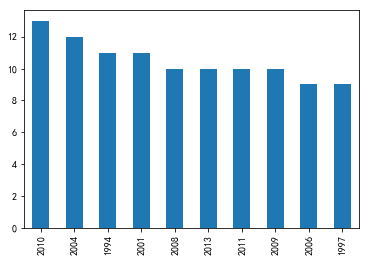

In [5]:
year_sta = df.year.value_counts()
year_sta[:10].plot.bar();

可以看出，2010 年是产生高评分电影最多的一年。

### 21 世纪高评分电影的趋势

先筛选出21世纪高评分的电影，然后进行统计。

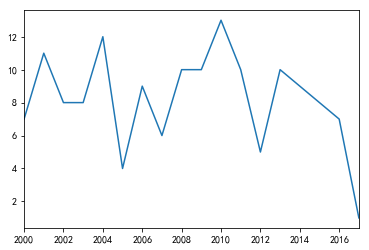

In [6]:
year_21century = df[df.year >= 2000].year.value_counts().sort_index()
year_21century.plot.line();

可以看出，21世纪之后，随着时间的推移高评分的电影数量并非越来越多。其中2004和2010是高产的两年，2017是最低的一年。

### 产出的高评分电影最多地区Top10

对所有的地区进行统计，由于有的电影会出现多个地区，所以需要分开统计。

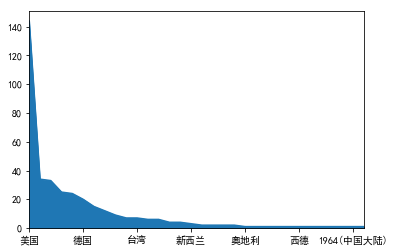

In [7]:
place = []
for i in df.place.str.split(" ").values:
    for j in i:
        place.append(j)
# 求出不同地区的次数
place_count = Counter(place)
# 对结果进行排序
place_count = sorted(place_count.items(), key=lambda item: item[-1], reverse=True)
# 将结果进行组装
place_count = list(zip(*place_count))
# 构建 Series
place_count_series = pd.Series(data=place_count[1], index=place_count[0])

place_count_series.plot.area();

从上面一眼就能看出来，美国的好莱坞不是吹出来的~

我们再来看看比例吧，这里将前9的地区罗列出来，其他的地区的都记为“其他”。

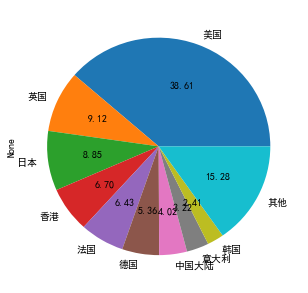

In [8]:
place_count_series2 = place_count_series[:9]
place_count_series2["其他"] = place_count_series[9:].sum()
place_count_series2.plot.pie(figsize=(5, 5), autopct="%.2f");

不比不知道，一比吓一跳，美国产出的高评分电影占据了接近 40% 的比例。并且比前9之外的地区加起来的总数还多出了1倍多。

### 产出的高评分电影最多体裁Top10

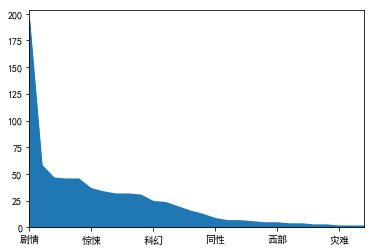

In [9]:
genre = []
for i in df.genre.str.split(" ").values:
    for j in i:
        genre.append(j)
# 求出不同体裁的次数
genre_count = Counter(genre)
# 对结果进行排序
genre_count = sorted(genre_count.items(), key=lambda item: item[-1], reverse=True)
# 将结果进行组装
genre_count = list(zip(*genre_count))
# 构建 Series
genre_count_series = pd.Series(data=genre_count[1], index=genre_count[0])

genre_count_series.plot.area();

### 评分最高的电影Top10

直接按照评分字段排序，获取前十即可。

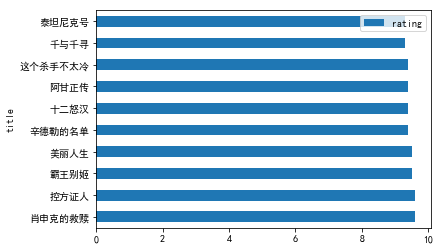

In [10]:
rating_top10 = df.sort_values(by="rating", ascending=False)[:10]
rating_top10.plot.barh(x="title", y="rating");

肖克申的救赎高居第1位，泰坦尼克号位居第10位。

## 评论人数最多电影Top10

按照评论人数的进行排序，取前10即可。

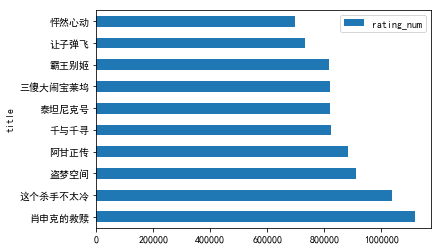

In [11]:
rating_num_top10 = df.sort_values(by="rating_num", ascending=False)[:10]
rating_num_top10.plot.barh(x="title", y="rating_num");

肖克申的救赎高居第1位，怦然心动位居第10位。

### 评论人数与评分高低之间的关系

想要获取他们之间的关系，通过散点图即可得到。

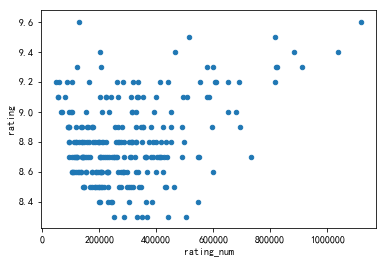

In [12]:
df.plot.scatter(x="rating_num", y="rating");

可以看到，评论人数的多少和电影评分的高低并没绝对的线性关系。

### 实力派导演Top10

想要获取实力派导演Top10，也就是需要统计每个导演的高评分电影个数，我们可以从 `director_and_performer` 字段中获取导演名称。

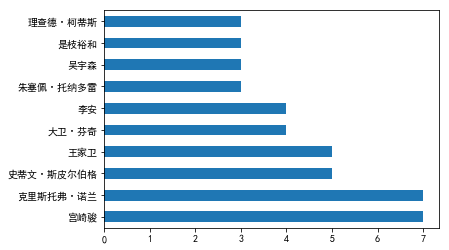

In [13]:
director = df.director_and_performer.map(lambda x: x.split(":")[1].strip().split(" ")[0])
director.value_counts()[:10].plot.barh();

宫崎骏和克里斯托弗·诺兰这两位导演真特么牛逼啊，各自导演的高评分电影有 7 个。